# 2: Power Outage Identification: Preprocessing and Word2Vec Model

### Contents:
- [Imports](#Imports)
- [Preprocessing](#Preprocessing)
- [Word2Vec Model](#Word2Vec-Model)
  * [Train Model](#Train-Model)
- [t-SNE Model Exploration](#t-SNE-Model-Exploration)  
  * [Visualization](#Visualization)
  * [Exporting Visual](#Exporting-Visual)
- [Evaluation](#Evaluation)  

## Imports

In [30]:
# Importing packages
from __future__ import absolute_import, division, print_function
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
from nltk.corpus import stopwords

#importing warnings to turn off future warnings
import warnings
warnings.simplefilter(action='ignore')

## Preprocessing

Based on what we learned when reviewing our data in EDA, we set out to prepare the text for modeling by lower casing all words and removing punctuation and stopwords. We also removed complete url strings before tokenizing to make sure we captured all the url pieces, especially link shorteners. We printed out a sample tweet as it was altered to confirm that each step processed correctly.

In [31]:
#reading in the data
all_tweets_df = pd.read_csv('../datasets/combined_data.csv')
all_tweets_df.drop(columns='Unnamed: 0', inplace = True)
print(f'Shape of DataFrame: {all_tweets_df.shape}')
all_tweets_df.head()

Shape of DataFrame: (6670, 9)


id                                               text  \
0  973258558686027776  Power outage in the area causing delays. treat...   
1  901865645813399552  More wind and more rain in Austin today. Power...   
2  767159069186543616  South Austin outage partially restored. ~936 r...   
3  767122315947626496  Power outage in South Austin affecting ~3500 c...   
4  765714039594811392  Power outage affecting ~1,438 customers in the...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1  2017-08-27 17:55:00        AusTxNerd   Austin  2017-08-27   
2  2016-08-21 00:39:09        Austin_CP   Austin  2016-08-21   
3  2016-08-20 22:13:07        Austin_CP   Austin  2016-08-20   
4  2016-08-17 00:57:07        Austin_CP   Austin  2016-08-17   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2017-08-27, Austin      torrential, hot, hot ||   
2  2016-08-21, Austin  downpour, scorching, hot ||   
3  2016-08-20, Austin      torrential, hot, hot ||   
4  2016-08-17, Austin        downpour, hot, hot ||   

                                            all_text  
0  Power outage in the area causing delays. treat...  
1  More wind and more rain in Austin today. Power...  
2  South Austin outage partially restored. ~936 r...  
3  Power outage in South Austin affecting ~3500 c...  
4  Power outage affecting ~1,438 customers in the...

In [32]:
# create series just containing the text column
all_tweets = all_tweets_df['all_text']
print(f'Number of tweets: {len(all_tweets)}')

Number of tweets: 6670


In [33]:
# setting stopwords
stop_words = stopwords.words('english')

In [34]:
# Function to clean up tweets (removing urls, non-alphabetical characters)
def tweets_to_tweetlist(raw):
    clean = re.sub(r"[^a-zA-Z ]", "", raw)
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    clean = re.sub(r'instagramcom.*?\b','',clean)
    return clean

In [35]:
# Iterate through all_tweets, clean tweets and add to tweet_list
tweet_list = []
for tweet in all_tweets:
    tweet_list.append(tweets_to_tweetlist(tweet))
len(tweet_list)

6670

In [36]:
# Iterate through tweet_list convert to lowercase and tokenize each tweet
tokenized_tweet_list = [tweet.lower().split(' ') for tweet in tweet_list]   

In [37]:
# Remove stop words from tweets
# final_tweet_list is the version of our tweet list we will use from here on
final_tweet_list = []
for tweet in tokenized_tweet_list:
    word_list = []
    for word in tweet:
        if (word not in stop_words) & (word != ''):
            word_list.append(word)
    final_tweet_list.append(word_list)

In [38]:
#Seeing how many tweets we'll be working with
len(final_tweet_list)

6670

In [39]:
# Count number of words in tweets list (all tweets)
token_count = sum([len(tweet) for tweet in final_tweet_list])
print(f"The tweet list contains {token_count} tokens")

The tweet list contains 80066 tokens


In [40]:
# Compare different versions of tweets and see how they changed
def compare_tweets(n):    
    print(all_tweets[n]) # original version of nth tweet
    print()
    print(tweet_list[n]) # cleaned version of nth tweet
    print()
    print(tokenized_tweet_list[n]) # tokenized version of nth tweet
    print()
    print(final_tweet_list[n]) # tokenized version of nth tweet (stopwords removed)

In [41]:
#calling the first tweet 
compare_tweets(0)

Power outage in the area causing delays. treat as all way stop. in #Austin on Parmer Ln at Dessau Rd #ATXtraffic http://bit.ly/10BGKax , dry, hot, cold ||

Power outage in the area causing delays treat as all way stop in Austin on Parmer Ln at Dessau Rd ATXtraffic  dry hot cold 

['power', 'outage', 'in', 'the', 'area', 'causing', 'delays', 'treat', 'as', 'all', 'way', 'stop', 'in', 'austin', 'on', 'parmer', 'ln', 'at', 'dessau', 'rd', 'atxtraffic', '', 'dry', 'hot', 'cold', '']

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']


## Word2Vec Model

We chose to use Word2Vec to model our data because of the way it focuses on the relationship of words and gives weight to that value. It maps the words from our dataset into a high dimensional space using a neural network. From that, we are able to train the model so that it can “learn” the conceptual relationship between words.  We wanted to use Word2Vec because it brings context of word choices into play, which will give us a better understanding of the group of words used in a tweet to talk about a power outage.  

In [42]:
# Instantiate Word2Vec model
tweets2vec = w2v.Word2Vec(
    sg = 1, # skip-gram train algo
    seed = 42, # Random Number Generator to make results repeatable
    workers = multiprocessing.cpu_count(), # number of threads
    size = 300, # Dimensionality of the hidden layer
    min_count = 3, # how many times the word has to appear to be kept in the vocab.
    window = 7, # size of the window to train words
    sample = 1e-5 # downsampling setting for frequent words
)

In [43]:
# Build tweets2vec vocabulary, haven't trained it yet, just loading it into memory
tweets2vec.build_vocab(final_tweet_list)

In [44]:
# how long is our tweets2vec vocabulary?
print("Tweets2Vec vocabulary length:", len(tweets2vec.wv.vocab))

Tweets2Vec vocabulary length: 2711


### Train Model

We trained our model on our tweet list so that it could "learn" the relationship of the words in the dataset.

In [45]:
# Train tweets2vec model on final_tweet_list
tweets2vec.train(final_tweet_list, total_examples=tweets2vec.corpus_count, epochs=tweets2vec.epochs)

(48828, 400330)

In [46]:
# Create directory to store our trained tweets2vec model in
if not os.path.exists("../datasets/training_model"):
    os.makedirs("../datasets/training_model")

In [47]:
# Save our trained tweets2vec model in the trained folder
tweets2vec.wv.save("../datasets/training_model/tweets2vec.w2v")

## t-SNE Model Exploration

While machines have no problem understanding high dimensional space, we needed to convert it back to two-dimensional space in order to examine and understand it. We used a t-SNE model for dimensionality reduction. 

Interpretability of t-SNE plots is not really intuitive right away. However what the plot is suppose to reveal is the relationships these words have to one another. Similar words or words that have a high probability appearing together will be close together in this plot while others without a positive relationship will appear further away. In the future we should consider running multiple versions of a t-SNE plot as each run, each parameter change, and each training session of the model can create a different plot with different interpretations. 

In [48]:
# reading in the trained data to explore it
tweets2vec = tweets2vec.wv.load("../datasets/training_model/tweets2vec.w2v")

This is a word vector in 300 dimensional word space. We need to take it down a bit using TSNE. That is t-distributed Stochastic Neighbor Embedding. Essentially it is a tool to visualize high-dimensional data. It takes a 300 dimensional vector and squashes it into 2 and derives coordinates from them.

In [49]:
# Here we are instantiating the t-SNE plot and establishing the parameters. 
tsne = sklearn.manifold.TSNE(n_components = 2, random_state = 42, perplexity= 70,learning_rate = 150,verbose =1,n_iter=5000)

Right now the tweets and their words are vectorized, converted into numbers. We need to convert them to word embeddings to start plotting them on the map in 2D.

In [50]:
#Coverting to word embeddings
all_word_vectors_matrix = tweets2vec.wv.syn0

In [51]:
# Training it will take some time...
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2711 samples in 0.019s...
[t-SNE] Computed neighbors for 2711 samples in 3.645s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2711
[t-SNE] Computed conditional probabilities for sample 2000 / 2711
[t-SNE] Computed conditional probabilities for sample 2711 / 2711
[t-SNE] Mean sigma: 0.003667
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.411530
[t-SNE] KL divergence after 1900 iterations: 2.948696


In [52]:
#creating a dataframe of the t-SNE coordinates
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[tweets2vec.vocab[word].index])
            for word in tweets2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [53]:
# Edited code from Boom Devahastin Na Ayudhya
# Define vectorization function
def vectorize_corpus(keyword_list):    
    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,300))                 
    
    # Scan through each word in list
    for word in keyword_list:
        if word in tweets2vec.vocab:                    
            word_vec = tweets2vec.word_vec(word)        
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 

    # Compute average vector by taking cumulative vector sum and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    
    # Squeeze this N-dimensional nested array object into a 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    
    return(corpus_avg_vec)

In [54]:
#defining cosine similarity function
def cos_sim(vector_1, vector_2):
    dp = np.dot(vector_1, vector_2)
    magnitude_v1 = np.sqrt(np.dot(vector_1,vector_1))
    magnitude_v2 = np.sqrt(np.dot(vector_2,vector_2))
    return(dp/(magnitude_v1*magnitude_v2))

To classify our tweets, we set up a list of positive and negative words for them to be compared to, using a cosine similarity score. The keyword lists were developed by exploring the dataset and extracting words that related more to power outages versus words that related to outages that were not power related. These included telecommunications outages as well as websites doing down such as Netflix or Facebook.

We edited this list as we fine tuned our model, watching for any misclassification word patterns.

In [66]:
#creating our pos/neg keyword lists 

# List of words for legitimate outages
power_out = ['generators','flooding','austinenergy','santaclarapower','grid', 'massive',
           'failure','generator','darkness','utoutage','powers','txuenergy','thunderstorms',
           'major', 'serious', 'surge', 'storm','storms','transformer','power','windstorm',
           'substation', 'alert', 'electrical', 'lights','thunderstorm','snake',
           'lightning','electricity','poweroutage','delays','atxoutage','nopower','lightsout',
           'candlelight','candle','candles','comed','coned','conedison','cnpalerts']

# List of words for non-legitimate outages (such as internet, Netflix, Facebook, or other service outages)
not_out = ['lines','whatsapp','aws','airworldwide','broadband','askspectrum','amtrack','dropbox',
               'twitter','skype','instagram','insta','espnfantasy','directv','netflix',
               'hulu', 'warner','microsoft','cable','tw','service','time',
               'twc','itunes','apple','attcares','attcustomercare','att','phones',
               'youtube','yt','facebook','centurylink','connectivity','network',
               'gmail','uverse', 'verizon', 'tmobile', 'phone', 'sprintcare',
               'sprint','wifi','internet', 'wireless', 'comcast','rcn','grandecom',
               'comcastcares','rcnconnects','playstation','sony','xfinity',
               'ig','fb','twchelp','nationwide','google','googlefiber','frontier','frontiercorp']

In [67]:
#vectorizing the keyword lists
power_out_vec = vectorize_corpus(power_out)
not_out_vec = vectorize_corpus(not_out)

In [68]:
#scoring words against our keywords
points['power_out_cs'] = [cos_sim(tweets2vec.word_vec(word),power_out_vec) for word in points['word']]
points['not_out_cs'] = [cos_sim(tweets2vec.word_vec(word),not_out_vec) for word in points['word']]
points['power_out_label'] = np.where(points['power_out_cs'] >= points['not_out_cs'],'power_out','not_out')
points.head()

word         x         y  power_out_cs  not_out_cs power_out_label
0    power -0.478999 -6.467056      0.960557    0.928083       power_out
1   outage -0.479923 -6.463121      0.937824    0.922289       power_out
2     area -0.429235 -5.730284      0.687003    0.681247       power_out
3  causing  0.911604 -3.786882      0.510800    0.499606       power_out
4   delays  1.285840 -2.274597      0.467867    0.423021       power_out

In [69]:
#getting the counts for each label
points['power_out_label'].value_counts()

power_out    1770
not_out       941
Name: power_out_label, dtype: int64

In [70]:
#sorting to see what words appear up top for legitimate power outages
points[points['power_out_label'] == 'power_out'].sort_values(by = 'power_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
0         power -0.478999 -6.467056      0.960557    0.928083       power_out
12          dry -0.478856 -6.466028      0.952991    0.913969       power_out
93         warm -0.479090 -6.466640      0.944750    0.928912       power_out
1        outage -0.479923 -6.463121      0.937824    0.922289       power_out
13          hot -0.479640 -6.458609      0.934584    0.914383       power_out
14         cold -0.478956 -6.435780      0.929448    0.900728       power_out
321    freezing -0.473447 -6.374351      0.904765    0.877019       power_out
45      without -0.471949 -6.361428      0.898110    0.877246       power_out
22   torrential -0.467399 -6.306401      0.874053    0.847866       power_out
32     downpour -0.459854 -6.223999      0.848504    0.821407       power_out

In [71]:
#seeing what the top are for not a legitamate power outage
points[points['power_out_label'] == 'not_out'].sort_values(by = 'not_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
702    thousands -0.425459 -5.998095      0.734915    0.756167         not_out
183       school -0.428154 -5.935357      0.721236    0.733344         not_out
154         time -0.408852 -5.689366      0.709501    0.728517         not_out
1022     comcast -0.408567 -5.530973      0.656043    0.673981         not_out
1055  nationwide  0.048181 -5.017917      0.633565    0.648825         not_out
277        lines -0.430307 -5.467970      0.637068    0.648127         not_out
1270    exchange -0.468263 -5.173677      0.629978    0.630441         not_out
200     facebook -0.392813 -4.516535      0.588653    0.627241         not_out
162          see -0.688971 -4.845376      0.609083    0.622047         not_out
71       service -0.173371 -4.492960      0.577927    0.617856         not_out

In [72]:
#checking out what words are most similar to the word "power"
tweets2vec.most_similar("power", topn=10)

[('warm', 0.9613915681838989),
 ('dry', 0.95769202709198),
 ('outage', 0.9567241668701172),
 ('hot', 0.9482302665710449),
 ('cold', 0.9385360479354858),
 ('freezing', 0.9147626757621765),
 ('without', 0.9069029092788696),
 ('torrential', 0.8812828063964844),
 ('downpour', 0.857241153717041),
 ('im', 0.8499487042427063)]

In [73]:
#checking out what words are most similar to the word "outage"
tweets2vec.most_similar("outage")

[('power', 0.9567241668701172),
 ('warm', 0.9484716653823853),
 ('dry', 0.9454604387283325),
 ('hot', 0.9446463584899902),
 ('cold', 0.9324482679367065),
 ('freezing', 0.904486894607544),
 ('without', 0.8999651670455933),
 ('torrential', 0.8731369972229004),
 ('line', 0.8430156111717224),
 ('downpour', 0.8429875373840332)]

In [74]:
#taking a look at each tweet with both scores so we can review what word groups were used to create the score
#this is helpful for fine tuning the model
for tweet in final_tweet_list:
    print(tweet)
    tweet_avg_vec = vectorize_corpus(tweet)
    print(f'Power Out CS: {cos_sim(tweet_avg_vec,power_out_vec)}')
    print(f'Not Out CS: {cos_sim(tweet_avg_vec,not_out_vec)}')

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']
Power Out CS: 0.9615938322110549
Not Out CS: 0.9302608023313075
['wind', 'rain', 'austin', 'today', 'power', 'neighborhood', 'since', 'send', 'coffee', 'torrential', 'hot', 'hot']
Power Out CS: 0.9559081845111346
Not Out CS: 0.9288226929308024
['south', 'austin', 'outage', 'partially', 'restored', 'remain', 'wo', 'power', 'estimated', 'restoration', 'pm', 'cause', 'lightning', 'downpour', 'scorching', 'hot']
Power Out CS: 0.9554312001271896
Not Out CS: 0.9338092258907703
['power', 'outage', 'south', 'austin', 'affecting', 'customers', 'help', 'way', 'atxoutage', 'torrential', 'hot', 'hot']
Power Out CS: 0.9583338665438281
Not Out CS: 0.9315552063775466
['power', 'outage', 'affecting', 'customers', 'wells', 'branchpark', 'bendmopac', 'area', 'crews', 'en', 'route', 'atxoutage', 'downpour', 'hot', 'hot']
Power Out CS: 0.959378200585105
Not

Not Out CS: 0.9221010533342373
['experiencing', 'intermittent', 'network', 'issues', 'due', 'data', 'center', 'power', 'outage', 'working', 'resolve', 'dry', 'cold', 'freezing']
Power Out CS: 0.9600940286835262
Not Out CS: 0.9376287707430053
['comed', 'reporting', 'still', 'without', 'power', 'chicago', 'area', 'torrential', 'cold', 'cold']
Power Out CS: 0.9571005908405792
Not Out CS: 0.9220732190416557
['samson', 'roasting', 'open', 'fire', 'poweroutage', 'chritmascardsbycandlelight', 'rain', 'cold', 'freezing']
Power Out CS: 0.9446044451539392
Not Out CS: 0.9126864309062528
['power', 'outage', 'norwood', 'park', 'neighborhood', 'chicago', 'il', 'torrential', 'warm', 'cold']
Power Out CS: 0.9641299066737475
Not Out CS: 0.9356888219816404
['get', 'home', 'f', 'power', 'outage', 'hour', 'wait', 'power', 'might', 'back', 'ugh', 'dry', 'warm', 'cold']
Power Out CS: 0.9665930142867404
Not Out CS: 0.9357487193983874
['walgreens', 'computer', 'outage', 'delays', 'prescriptions', 'nationwide'

Power Out CS: 0.9666399430639019
Not Out CS: 0.9389400580109716
['candlesayshi', 'smokes', 'rcnconnects', 'im', 'lakeview', 'east', 'theres', 'outage', 'area', 'internet', 'past', 'hour', 'lost', 'tv', 'dry', 'hot', 'warm']
Power Out CS: 0.957828829301684
Not Out CS: 0.9378987252431091
['theirishfish', 'st', 'subway', 'ridelost', 'power', 'awesome', 'drizzle', 'hot', 'warm']
Power Out CS: 0.9611535911446402
Not Out CS: 0.9332037871163967
['comcastcares', 'internet', 'outage', 'wifi', 'says', 'slow', 'internet', 'connection', 'mobilecarexv', 'drizzle', 'hot', 'warm']
Power Out CS: 0.9538176453569699
Not Out CS: 0.9365516002472953
['sitting', 'park', 'power', 'outage', 'kenwood', 'park', 'torrential', 'hot', 'warm']
Power Out CS: 0.9599157988760546
Not Out CS: 0.935095191619639
['switching', 'providers', 'internet', 'outage', 'isnt', 'sorted', 'soon', 'comcast', 'youre', 'game', 'town', 'dry', 'hot', 'warm']
Power Out CS: 0.9557915925584626
Not Out CS: 0.9359794765811287
['better', 'get'

Power Out CS: 0.9515981167727907
Not Out CS: 0.9104227862825167
['heating', 'outage', 'east', 'south', 'campus', 'great', 'needed', 'cold', 'bundledup', 'rain', 'cold', 'freezing']
Power Out CS: 0.949079151844327
Not Out CS: 0.9253833852368345
['comed', 'give', 'info', 'call', 'got', 'notifying', 'planned', 'outage', 'area', 'tonight', 'rain', 'cold', 'freezing']
Power Out CS: 0.9459595413611455
Not Out CS: 0.9194403164234729
['power', 'work', 'still', 'dry', 'freezing', 'freezing']
Power Out CS: 0.963226627946538
Not Out CS: 0.9309623759191568
['power', 'fordham', 'like', 'today', 'drizzle', 'cold', 'freezing']
Power Out CS: 0.9636168037274685
Not Out CS: 0.9288285094613301
['completely', 'random', 'power', 'outage', 'middle', 'day', 'bad', 'weather', 'either', 'time', 'leave', 'house', 'errands', 'drizzle', 'cold', 'freezing']
Power Out CS: 0.961307795693415
Not Out CS: 0.9361011611937009
['power', 'hoodthey', 'said', 'hours', 'dry', 'cold', 'freezing']
Power Out CS: 0.96526305418192

Not Out CS: 0.9350716235835826
['etrevor', 'aepohio', 'reporting', 'customers', 'without', 'power', 'coshocton', 'county', 'ctnow', 'hopefully', 'one', 'em', 'stevencrowtown', 'torrential', 'hot', 'warm']
Power Out CS: 0.9587461905273469
Not Out CS: 0.9334325487235866
['oh', 'lord', 'sump', 'pump', 'well', 'filling', 'fast', 'power', 'torrential', 'hot', 'warm']
Power Out CS: 0.9579716263285815
Not Out CS: 0.9328094925508674
['power', 'cool', 'torrential', 'hot', 'warm']
Power Out CS: 0.96130499751605
Not Out CS: 0.9361413418294152
['shay', 'bummer', 'makes', 'feel', 'better', 'power', 'soooo', 'cant', 'watch', 'either', 'good', 'one', 'tonight', 'torrential', 'hot', 'warm']
Power Out CS: 0.9547053183740404
Not Out CS: 0.9332300279103968
['power', 'outage', 'hour', 'dry', 'hot', 'warm']
Power Out CS: 0.9657562516051486
Not Out CS: 0.9401351335688909
['deelightful', 'power', 'house', 'hot', 'melting', 'cranky', 'dry', 'hot', 'warm']
Power Out CS: 0.9636388357432295
Not Out CS: 0.9376382

['power', 'outage', 'work', 'affects', 'computer', 'yes', 'please', 'friday', 'firstworldproblems', 'winning', 'twiddlemythumbs', 'dry', 'hot', 'warm']
Power Out CS: 0.9606401453334589
Not Out CS: 0.9388722766575814
['power', 'forealll', 'better', 'last', 'long', 'rain', 'hot', 'hot']
Power Out CS: 0.9523696318540685
Not Out CS: 0.9308848220631174
['power', 'gym', 'title', 'keep', 'going', 'torrential', 'hot', 'warm']
Power Out CS: 0.9571289888911826
Not Out CS: 0.9346029014302336
['sucks', 'people', 'without', 'power', 'torrential', 'hot', 'warm']
Power Out CS: 0.9624968400620366
Not Out CS: 0.9363719920484705
['turned', 'ac', 'case', 'power', 'went', 'great', 'preemptive', 'power', 'outage', 'strategy', 'geniusprobz', 'dfw', 'torrential', 'hot', 'warm']
Power Out CS: 0.9632645982011855
Not Out CS: 0.9383009317692164
['power', 'outlet', 'nfldraft', 'twitter', 'darkness', 'torrential', 'hot', 'warm']
Power Out CS: 0.9621618274428477
Not Out CS: 0.9388459102409308
['power', 'house', 'to

['april', 'giraffe', 'live', 'stream', 'back', 'outage', 'birth', 'live', 'rain', 'warm', 'cold']
Power Out CS: 0.9459452352353239
Not Out CS: 0.9226209325167464
['yearold', 'oxygen', 'still', 'without', 'power', 'huntington', 'woods', 'dry', 'freezing', 'freezing']
Power Out CS: 0.9580898519047235
Not Out CS: 0.9310965042855509
['dte', 'energy', 'percent', 'customers', 'power', 'restored', 'still', 'without', 'power', 'downpour', 'freezing', 'freezing']
Power Out CS: 0.9584898039578589
Not Out CS: 0.9317139748520804
['still', 'experiencing', 'technical', 'difficulties', 'due', 'weather', 'outage', 'internet', 'downpour', 'freezing', 'freezing']
Power Out CS: 0.9458988515520527
Not Out CS: 0.9249342424271709
['update', 'power', 'outages', 'died', 'carbon', 'monoxide', 'poisoning', 'lost', 'power', 'using', 'generator', 'rain', 'freezing', 'freezing']
Power Out CS: 0.9573122484571578
Not Out CS: 0.9233270027064284
['dte', 'energy', 'says', 'customers', 'without', 'power', 'goal', 'get',

Power Out CS: 0.9630450632318872
Not Out CS: 0.9378776643652368
['detroitredwings', 'partial', 'power', 'outage', 'drizzle', 'warm', 'cold']
Power Out CS: 0.9628416136468976
Not Out CS: 0.9381862124088106
['tammyharvey', 'sec', 'game', 'poweroutage', 'redwings', 'drizzle', 'warm', 'cold']
Power Out CS: 0.9485018711594927
Not Out CS: 0.9167843505462142
['boothie', 'jmbooth', 'boothrachael', 'power', 'outage', 'joe', 'seconds', 'st', 'period', 'drizzle', 'warm', 'cold']
Power Out CS: 0.959520772449566
Not Out CS: 0.9353862730905382
['tmoniz', 'lost', 'power', 'lol', 'drizzle', 'warm', 'cold']
Power Out CS: 0.9635164396675633
Not Out CS: 0.9336196775805824
['good', 'call', 'whoever', 'djing', 'lights', 'outage', 'right', 'babywhenthelightsgoout', 'drizzle', 'warm', 'cold']
Power Out CS: 0.9550677269077802
Not Out CS: 0.9291743355681491
['power', 'outage', 'joe', 'haha', 'drizzle', 'warm', 'cold']
Power Out CS: 0.9622176104099811
Not Out CS: 0.9362788352858735
['lost', 'power', 'today', 'n

['xfinity', 'outage', 'area', 'may', 'resolved', 'pm', 'tonight', 'thats', 'minutes', 'late', 'gameofthrones', 'yourservicesucks', 'whycompetitionisgood', 'torrential', 'warm', 'cold']
Power Out CS: 0.9525003675695887
Not Out CS: 0.9303478548354573
['lost', 'power', 'cheddars', 'im', 'tryna', 'make', 'moneyyyyygg', 'torrential', 'warm', 'cold']
Power Out CS: 0.9596175756863226
Not Out CS: 0.9350466638950038
['sundaymorning', 'outage', 'strikes', 'facebook', 'instagram', 'whatsapp', 'uncategorized', 'feedly', 'torrential', 'warm', 'cold']
Power Out CS: 0.9510991451629545
Not Out CS: 0.9418485993513306
['cant', 'post', 'meal', 'prep', 'due', 'social', 'media', 'outage', 'torrential', 'warm', 'cold']
Power Out CS: 0.9507252413851819
Not Out CS: 0.9294763585273752
['woohoo', 'power', 'outage', 'pt', 'torrential', 'warm', 'cold']
Power Out CS: 0.9611447898462088
Not Out CS: 0.9356686380547263
['power', 'outage', 'probably', 'torrential', 'warm', 'cold']
Power Out CS: 0.9619095426445043
Not 

Not Out CS: 0.9112270321078367
['invention', 'takes', 'static', 'electricity', 'hair', 'please', 'dry', 'cold', 'freezing']
Power Out CS: 0.9567346064189133
Not Out CS: 0.925685630374791
['tmobilehelp', 'signal', 'philly', 'network', 'outage', 'dry', 'cold', 'freezing']
Power Out CS: 0.9545381953875389
Not Out CS: 0.930241641185962
['sure', 'catenary', 'problems', 'theyve', 'resulted', 'amtrak', 'stopped', 'without', 'power', 'mins', 'dry', 'cold', 'freezing']
Power Out CS: 0.9591555251601326
Not Out CS: 0.9268830342409062
['apartment', 'buildings', 'power', 'soooo', 'drinking', 'brown', 'shugga', 'lagunitasbruhws', 'kite', 'key', 'drizzle', 'cold', 'freezing']
Power Out CS: 0.953653239315853
Not Out CS: 0.9224063193738586
['power', 'praise', 'god', 'destroytheworksofthedevil', 'nccphilly', 'new', 'covenant', 'dry', 'cold', 'freezing']
Power Out CS: 0.9653626111976003
Not Out CS: 0.9326941916786422
['wassup', 'neighborhood', 'power', 'outage', 'dry', 'cold', 'freezing']
Power Out CS: 0

Not Out CS: 0.933723365709478
['acelecconnect', 'customers', 'without', 'power', 'gloucester', 'county', 'cpsj', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9614876320076741
Not Out CS: 0.9308318350548396
['radnor', 'emergency', 'report', 'traffic', 'signal', 'bryn', 'mawr', 'malin', 'generator', 'power', 'residents', 'without', 'power', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9628793402487426
Not Out CS: 0.9306359848911421
['theres', 'power', 'outage', 'cant', 'watch', 'house', 'cards', 'w', 'brgoch', 'valentines', 'day', 'im', 'going', 'boycott', 'philadelphia', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9609978135539314
Not Out CS: 0.9347887087079519
['im', 'little', 'nervous', 'storm', 'power', 'outage', 'would', 'ok', 'torrential', 'cold', 'freezing']
Power Out CS: 0.9597688096780218
Not Out CS: 0.9354746644563106
['dorm', 'lost', 'power', 'rain', 'freezing', 'freezing']
Power Out CS: 0.9517725147694488
Not Out CS: 0.9227959234223742
['bracing', 'next', 'dum

Power Out CS: 0.9532726887977042
Not Out CS: 0.9175904798684734
['emergency', 'equipment', 'replacementin', 'emergency', 'replace', 'providetransformerscircuit', 'breakersmotorsemergency', 'generators', 'outage', 'electriity', 'electric', 'dry', 'hot', 'warm']
Power Out CS: 0.9561853371847887
Not Out CS: 0.9298268546757893
['feeling', 'flight', 'lax', 'back', 'nyc', 'delayed', 'youve', 'gotten', 'text', 'powers', 'entire', 'block', 'home', 'thanks', 'noreaster', 'start', 'thinking', 'might', 'dry', 'hot', 'warm']
Power Out CS: 0.954131107517509
Not Out CS: 0.9296140542925428
['wind', 'storm', 'los', 'angeles', 'homes', 'beachwood', 'canyon', 'without', 'power', 'lets', 'pretend', 'camping', 'beachwood', 'canyon', 'dry', 'hot', 'warm']
Power Out CS: 0.9538453824961287
Not Out CS: 0.9270844906249205
['power', 'lordt', 'said', 'workout', 'time', 'poweroutage', 'compton', 'gainz', 'sandbag', 'gymime', 'cardio', 'rain', 'sweat', 'tears', 'swole', 'fitness', 'instafit', 'raingains', 'jesus',

Power Out CS: 0.9597327971705645
Not Out CS: 0.933522295315979
['power', 'outage', 'elements', 'spirit', 'never', 'dark', 'come', 'pick', 'candle', 'candle', 'holder', 'always', 'magick', 'light', 'home', 'gypsys', 'magick', 'elements', 'spirit', 'rain', 'scorching', 'hot']
Power Out CS: 0.9543904393402779
Not Out CS: 0.9290585635522581
['pm', 'mst', 'nw', 'mesa', 'maricopa', 'co', 'az', 'trained', 'spotter', 'reports', 'tstm', 'wnd', 'dmg', 'broken', 'limbs', 'shingles', 'vsby', 'mi', 'power', 'outage', 'dry', 'scorching', 'hot']
Power Out CS: 0.9586096004776335
Not Out CS: 0.9286500825738335
['pm', 'mst', 'e', 'arizona', 'state', 'unive', 'maricopa', 'co', 'az', 'amateur', 'radio', 'reports', 'tstm', 'wnd', 'dmg', 'power', 'outage', 'mcclintock', 'dr', 'apache', 'blvd', 'dry', 'scorching', 'hot']
Power Out CS: 0.9580935135787546
Not Out CS: 0.9312662280427468
['power', 'autozone', 'sucks', 'cant', 'buy', 'anything', 'power', 'mesa', 'arizona', 'dry', 'scorching', 'hot']
Power Out CS:

['power', 'outage', 'affects', 'north', 'side', 'homes', 'businesses', 'ktsanews', 'dry', 'hot', 'warm']
Power Out CS: 0.9615261684334776
Not Out CS: 0.9370520901786394
['animalrelated', 'power', 'outage', 'leaves', 'thousands', 'dark', 'north', 'side', 'dry', 'hot', 'warm']
Power Out CS: 0.9622021758217513
Not Out CS: 0.9394083024946486
['dm', 'ppl', 'without', 'power', 'aint', 'got', 'time', 'dry', 'hot', 'warm']
Power Out CS: 0.9625767440202024
Not Out CS: 0.9353853545710813
['animalrelated', 'power', 'outage', 'leaves', 'thousands', 'dark', 'north', 'side', 'dry', 'hot', 'warm']
Power Out CS: 0.9622021758217513
Not Out CS: 0.9394083024946486
['poweroutage', 'dry', 'hot', 'warm']
Power Out CS: 0.9643235084703592
Not Out CS: 0.9333404365137723
['breaking', 'cps', 'energy', 'reporting', 'power', 'outage', 'citys', 'north', 'side', 'left', 'customers', 'without', 'power', 'early', 'thursday', 'morning', 'dry', 'hot', 'warm']
Power Out CS: 0.9640745534452474
Not Out CS: 0.93727885754359

['power', 'windows', 'open', 'san', 'jose', 'marriott', 'dry', 'cold', 'cold']
Power Out CS: 0.9584181166185058
Not Out CS: 0.9261087569676189
['roughly', 'pge', 'customers', 'across', 'bay', 'area', 'without', 'power', 'hour', 'torrential', 'warm', 'warm']
Power Out CS: 0.9559191297907448
Not Out CS: 0.9311669926364698
['largest', 'pge', 'outage', 'right', 'reported', 'near', 'daly', 'city', 'impending', 'storm', 'could', 'knock', 'power', 'thousands', 'torrential', 'warm', 'cold']
Power Out CS: 0.958543420439468
Not Out CS: 0.9328150976166043
['blackout', 'power', 'outage', 'right', 'c', 'almost', 'pm', 'pst', 'power', 'better', 'come', 'back', 'dry', 'cold', 'freezing']
Power Out CS: 0.9652691819915368
Not Out CS: 0.9349886806052329
['santa', 'clara', 'county', 'building', 'w', 'hedding', 'st', 'closed', 'friday', 'due', 'power', 'outage', 'expected', 'reopen', 'dry', 'cold', 'freezing']
Power Out CS: 0.9600281593622241
Not Out CS: 0.9279831362545901
['ajhh', 'theres', 'nothing', 'q

In [75]:
#creating a dataframe of the scores, including noting areas of blackout
all_tweets_df['score_power_out']     = [cos_sim(vectorize_corpus(tweet),power_out_vec) for tweet in final_tweet_list]
all_tweets_df['score_not_out'] = [cos_sim(vectorize_corpus(tweet),not_out_vec) for tweet in final_tweet_list]
all_tweets_df['blackout']  = np.where(all_tweets_df['score_power_out'] >= all_tweets_df['score_not_out'],'power_out','not_out')
all_tweets_df.head()

id                                               text  \
0  973258558686027776  Power outage in the area causing delays. treat...   
1  901865645813399552  More wind and more rain in Austin today. Power...   
2  767159069186543616  South Austin outage partially restored. ~936 r...   
3  767122315947626496  Power outage in South Austin affecting ~3500 c...   
4  765714039594811392  Power outage affecting ~1,438 customers in the...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1  2017-08-27 17:55:00        AusTxNerd   Austin  2017-08-27   
2  2016-08-21 00:39:09        Austin_CP   Austin  2016-08-21   
3  2016-08-20 22:13:07        Austin_CP   Austin  2016-08-20   
4  2016-08-17 00:57:07        Austin_CP   Austin  2016-08-17   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2017-08-27, Austin      torrential, hot, hot ||   
2  2016-08-21, Austin  downpour, scorching, hot ||   
3  2016-08-20, Austin      torrential, hot, hot ||   
4  2016-08-17, Austin        downpour, hot, hot ||   

                                            all_text  score_power_out  \
0  Power outage in the area causing delays. treat...         0.961594   
1  More wind and more rain in Austin today. Power...         0.955908   
2  South Austin outage partially restored. ~936 r...         0.955431   
3  Power outage in South Austin affecting ~3500 c...         0.958334   
4  Power outage affecting ~1,438 customers in the...         0.959378   

   score_not_out   blackout  
0       0.930261  power_out  
1       0.928823  power_out  
2       0.933809  power_out  
3       0.931555  power_out  
4       0.933129  power_out

In [76]:
#checking out counts for blackout
all_tweets_df['blackout'].value_counts()

power_out    6670
Name: blackout, dtype: int64

In [77]:
#saving the csv
all_tweets_df.to_csv('../datasets/final_scored_data.csv')

## Visualization

The t-SNE plot lets us explore our dataset words visually. The words in blue represent the power being out, while gray words are associated with it not being a legitimate power outage.

In [78]:
#setting context style
sns.set_context("poster")

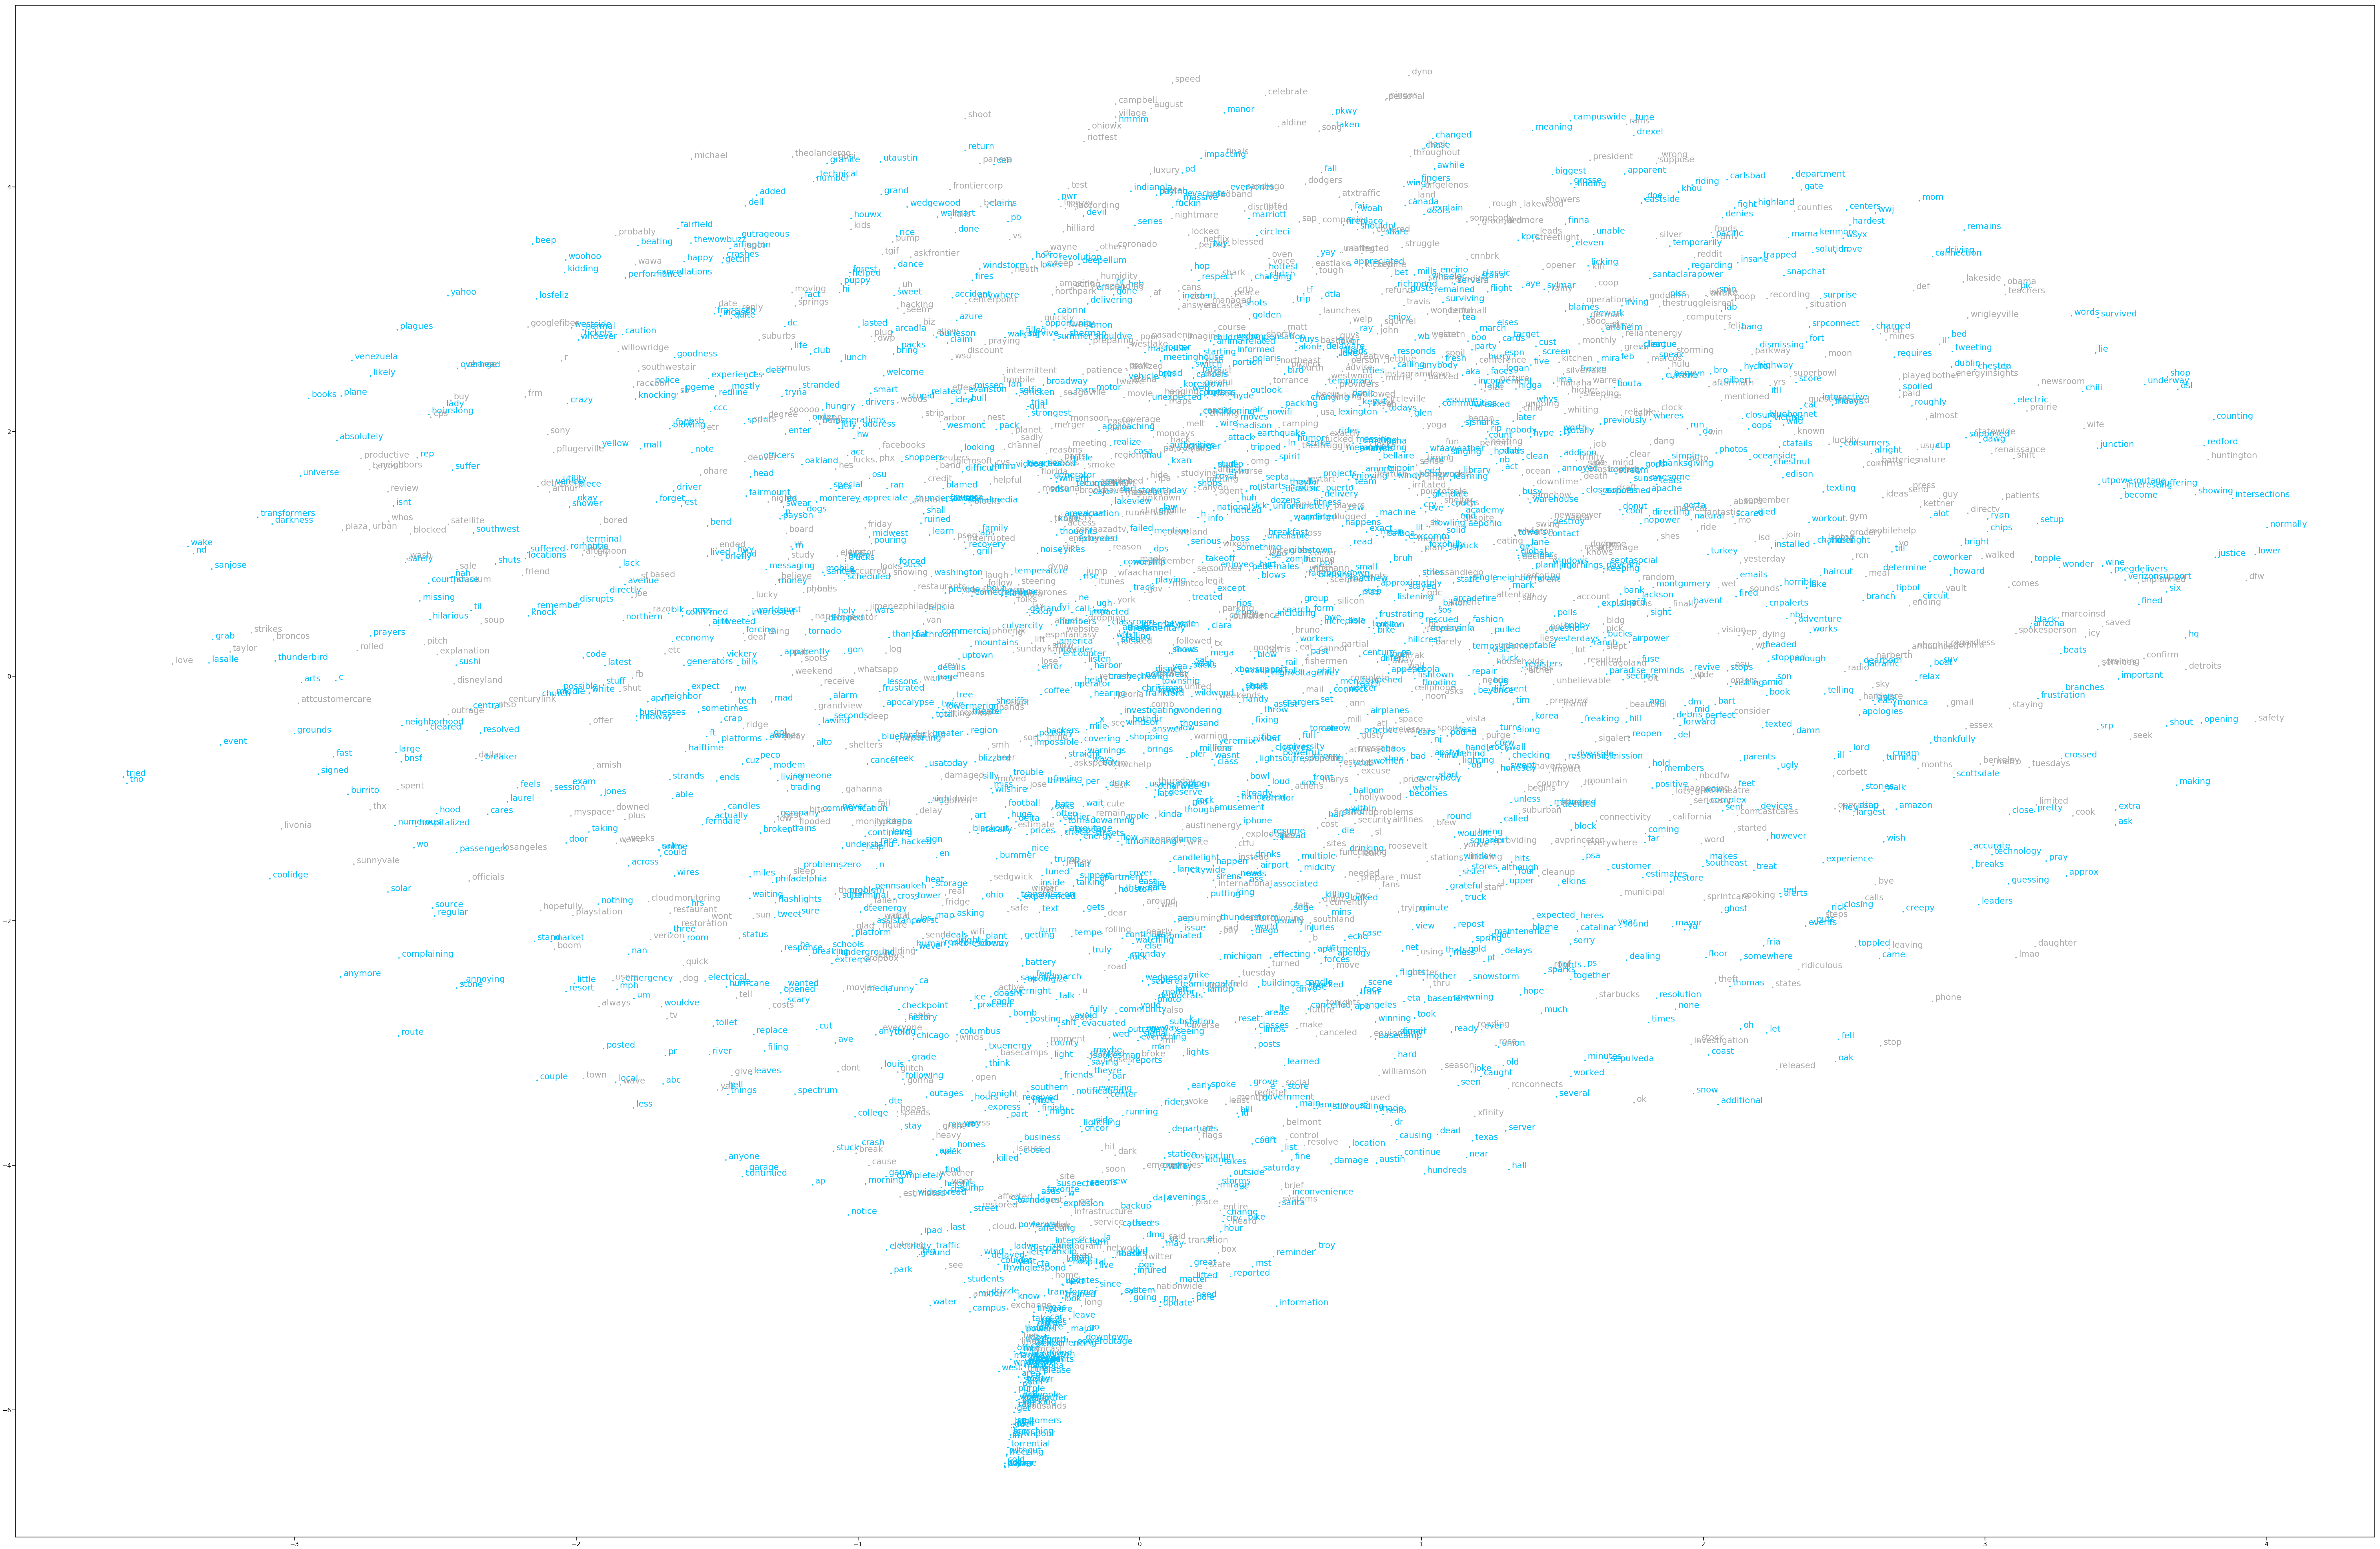

In [79]:
#plotting the t-SNE
plt.figure(figsize = (150,100))
colors = {'power_out':'deepskyblue', 'not_out':'darkgrey'}
for i,word in enumerate(points['word']):
    x = points['x'][i]
    y = points['y'][i]
    color = points['power_out_label'].apply(lambda x: colors[x])[i]
    plt.scatter(x, y, color=color, s = 10)
    plt.text(x+0.01, y+0.01, word,color = color, fontsize=30)
plt.show()

# to see the plot please zoom in. 

## Exporting Visual

This code will create and export an html file that will allow you to interact with the visual plot. The dots in blue represent the power being out, while gray dots are associated with it not being a legitimate power outage. The size of the dot also shows us how high it’s cosine similarity score is. Larger dots have larger scores, meaning a stronger relationship to either the positive or negative word list.

In [80]:
#creating and exporting an html file of the t-SNE plot

import numpy as np

from bokeh.plotting import figure, show, output_file,ColumnDataSource

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

source = ColumnDataSource(data = dict(
    x = points['x'],
    y = points['y'],
    label = points['power_out_label'],
    power_out_cs = points['power_out_cs'],
    not_out_cs = points['not_out_cs'],
    radii = ((points['power_out_cs']*points['power_out_label'].apply(lambda x: 1 if (x == 'power_out') else 0))+(points['not_out_cs']*points['power_out_label'].apply(lambda x: 0 if (x == 'power_out') else 1)))*0.25,
    color = points['power_out_label'].apply(lambda x: colors[x]),
    words = points['word']
))
TOOLTIPS =[
    ('word', '@words'),
    ('class','@label'),
    ('power out cos sim','@power_out_cs'),
    ('not out cos sim','@not_out_cs')
]
p = figure(title = 't-SNE Plot of Words in Tweets',
           tooltips=TOOLTIPS)

p.scatter('x', 'y', radius='radii', source = source,
          fill_color='color', line_color = None, fill_alpha=0.3)

output_file("../visualizations/tsne_scatter.html", title="tsne_scatter.py")

show(p)  # open a browser

## Evaluation

To evaluate our model’s performance, we had to manually confirm whether or not it was classified correctly. Ideally, we’d be able to go through all the tweets to confirm this but we ran out of time. We reviewed one thousand tweets and found six misclassifications. We’d need to review more to confirm whether this is what to expect in terms of number of misclassifications or an anomaly. From there we’d need to fine tune the model to lessen misclassifications. 

When we started this process, we believed that weather played a large role in power outages, and it does. However, we also discovered that the word “snakes” related high for flagging legitimate power outages. And that’s how we learned that snakes can climb into transformers and cause power outages. 

**Please continue to [3_Outage_Map_and_Next_Steps.ipynb](./3_Outage_Map_and_Next_Steps.ipynb) for the next step in the project: Outage Map**